# PULSAR Detection from HTRU2 Dataset

## 1. Introduction

HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey.

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter.

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars 
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes. 

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find. 

Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted, 
which treat the candidate data sets as binary classification problems. Here the legitimate pulsar examples are a minority positive class, and spurious examples the majority negative class. At present multi-class labels are unavailable, given the costs associated with data annotation.

## 1.1 About the Dataset
  

**Dataset:** https://archive.ics.uci.edu/ml/datasets/HTRU2

The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples. These examples have all been checked by human annotators. 

### Attribute Information

Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency (see [3] for more details). The remaining four variables are similarly obtained from the DM-SNR curve (again see [3] for more details). These are summarised below: 

1. Mean of the integrated profile. 
2. Standard deviation of the integrated profile. 
3. Excess kurtosis of the integrated profile. 
4. Skewness of the integrated profile. 
5. Mean of the DM-SNR curve. 
6. Standard deviation of the DM-SNR curve. 
7. Excess kurtosis of the DM-SNR curve. 
8. Skewness of the DM-SNR curve. 
9. Class 

HTRU 2 Summary 
17,898 total examples. 
1,639 positive examples. 
16,259 negative examples.

## 2. Loading the Dataset

In [1]:
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import numpy as np

# Models 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Score functions
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score , classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
# Function to plot Confusion Matrix
def plotCM(Y_test,Y_pred):
    print (metrics.classification_report(Y_test, Y_pred))
    print ("Confusion matrix")
    confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
    print (confusion_matrix)
    #normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    # Plot Results: 
    width = 5
    height = 5
    plt.figure(figsize=(width, height))
    plt.imshow(
        confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix - Decision Tree Classifier \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot a correlation map
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

# Function to depict the importance of a variable
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

# Beautiful distribution of plots
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

### 2.1 Reading the '.csv' Files

In [3]:
# read .csv from provided dataset
pulsar_data="./Data/HTRU_2.csv"
data = pd.read_csv(pulsar_data)

In [4]:
data.head()

,M1,ST1,EX1,SK1,M2,ST2,EX2,SK2,C
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [5]:
cols = list(data.columns)
features = cols
features.remove('C')

In [6]:
X = data[features]
Y = data['C']

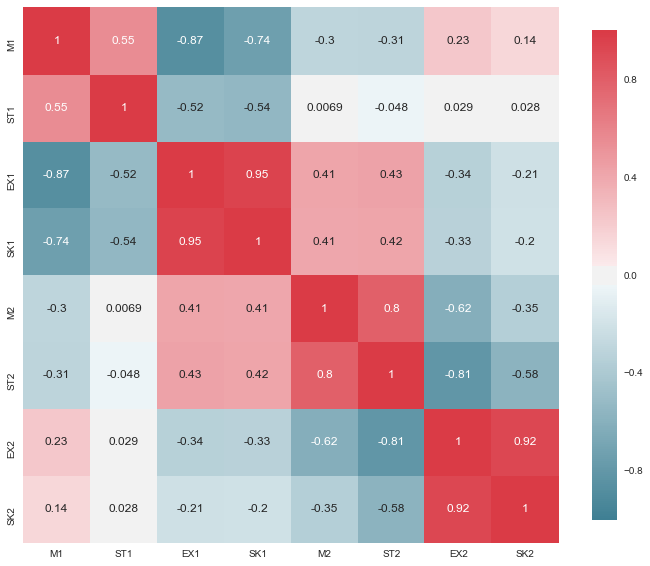

In [7]:
plot_correlation_map(X)

In [8]:
X = StandardScaler().fit_transform(X)

In [9]:
# Split dataset to 60% training and 40% testing
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.4, random_state=0)

In [10]:
df = pd.DataFrame({'M1':X[:,0],'ST1':X[:,1],'EX1':X[:,2],'SK1':X[:,3],'M2':X[:,4],'ST2':X[:,5],'EX2':X[:,6],'SK2':X[:,7]})

1.0


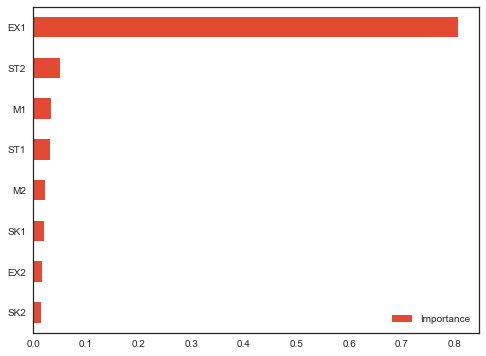

In [11]:
plot_variable_importance(df,Y)

In [12]:
print(X_train.shape, Y_train.shape)

(10738, 8) (10738,)


___

## 3. Clustering - A Unsupervised Learning Task

### TIPS: 
1. [Various Clustering Methods](http://scikit-learn.org/stable/modules/clustering.html#clustering)
2. [What metrics are we going to use?](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)
3. [Comparing different clustering algorithms on Toy Datasets](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

In [13]:
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans,AgglomerativeClustering

### Overview:
Eventhough, we are provided with a labelled dataset for our analysis. We would for first part of our implementation, treat it as a unlabelled dataset and try to run clustering algorithms to find out the distinct group of data points namely:
1. PCA
2. Agglomerative Clustering
3. KMeans
4. Affinity Propogation
5. MeanShift
6. Mixture of Gaussian Models

### 3.1 PCA - Principal Component Analysis

It is a precursor step to any analysis that we may subject to our dataset. The above dataset has decent dimensional feature space consisting of **8 features**. In such a high-dimensional space, Euclidean distances tend to become **inflated and meaningless**. This can severely impact our algorithms performance. Such a situation demands more data to train our model and this problem is called the **'Curse of Dimensionality'**.

The PCA algorithm solves this problem by finding out the features that explain the maximum variance. So, instead of training our models over 8 features we will be training them over **2** features that explain the maximum variance.

In [14]:
len(features)

8

In [15]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X)

# Print the components and the amount of variance in the data contained in each dimension

# print(pca.components_)
print(pca.explained_variance_)

[ 4.1340467   2.1446051   0.80934896  0.45742482  0.25822692  0.1598793
  0.02044194  0.01602625]


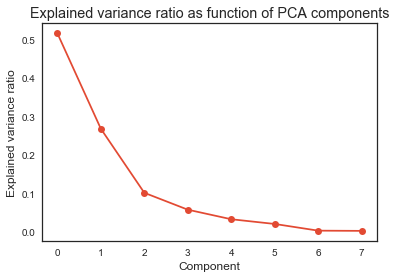

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component')
plt.show()

### 3.1.1 Create 'reduced_data' - a Feature Dataframe containing 2 components explaining Maximum Variance

In [17]:
# First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
#print(reduced_data[:10])  # print upto 10 elements

In [18]:
reduced_data.shape

(17898, 2)

## 3.2 Applying KMeans on 'reduced_data'

In [19]:
kmeans = cluster.KMeans(n_clusters=2)
clusters = kmeans.fit(reduced_data)
print(clusters)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [20]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.

xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [21]:
# Find the centroids for KMeans or the cluster means for Gaussian Mixed Model

centroids = kmeans.cluster_centers_

print('*** K MEANS CENTROIDS ***')
print(centroids)

# TRANSFORM DATA BACK TO ORIGINAL SPACE FOR ANSWERING 7

print('*** CENTROIDS TRANSFERRED TO ORIGINAL SPACE ***')
print(pca.inverse_transform(centroids))

*** K MEANS CENTROIDS ***
[[-0.43861262 -0.1064617 ]
 [ 6.01191215  1.45923393]]
*** CENTROIDS TRANSFERRED TO ORIGINAL SPACE ***
[[ 0.19627924  0.13893976 -0.21639243 -0.2086499  -0.12520202 -0.13567283
   0.11862305  0.0858532 ]
 [-2.69033199 -1.90439942  2.9660165   2.8598923   1.71610105  1.8596208
  -1.62592531 -1.17676028]]


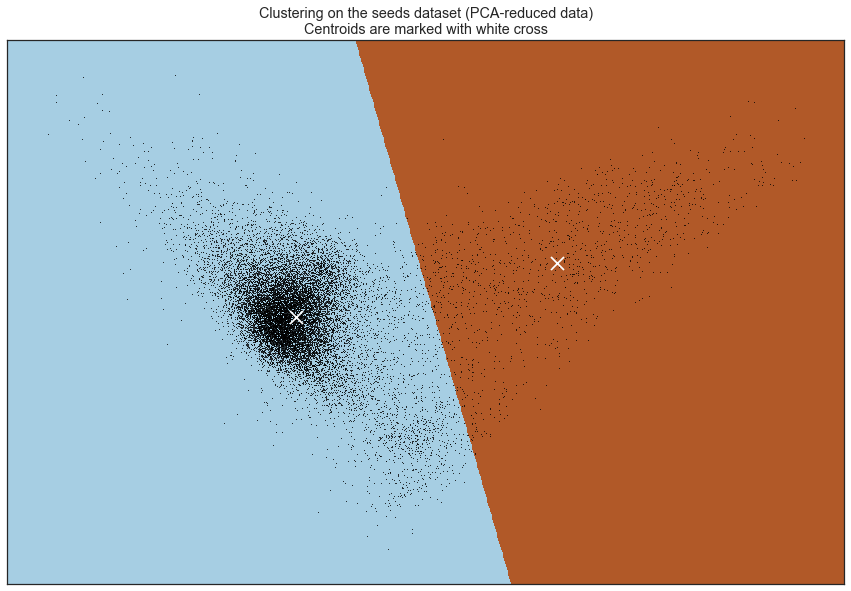

In [22]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1,figsize=(15,10))
plt.clf()
plt.imshow(Z, interpolation='Nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the seeds dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

____

## 3.3 [Applying Agglomerative Clustering 'reduced_data'](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Other Useful Tips:
1. [What is a Connectivity Matrix?](https://people.hofstra.edu/geotrans/eng/methods/connectivitymatrix.html)
2. [What is Precision & Recall? What is a Confusion Matrix?](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
3. [How to compute F-Score?](https://en.wikipedia.org/wiki/F1_score)
4. [What is a ROC Curve? How is it useful?](http://www.dataschool.io/roc-curves-and-auc-explained/)
5. [What is Cohen's Kappa?](https://en.wikipedia.org/wiki/Cohen's_kappa)

In [23]:
ac = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 0 0 ..., 0 0 0]


In [24]:
np.shape(labels)

(17898,)

___

### 3.3 [K Means Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

In [25]:
n_classes = 2
LABELS = [" Noise ","Pulsars"]

In [26]:
clf = cluster.KMeans(init='k-means++', n_clusters=2, random_state=5)
clf.fit(X_train)
print(clf.labels_.shape)
print(clf.labels_)

(10738,)
[0 0 0 ..., 0 0 0]


In [27]:
# Predict clusters on testing data
Y_pred = clf.predict(X_test)

             precision    recall  f1-score   support

          0       0.98      0.95      0.97      6566
          1       0.60      0.77      0.68       594

avg / total       0.95      0.94      0.94      7160

Confusion matrix
[[6265  301]
 [ 134  460]]


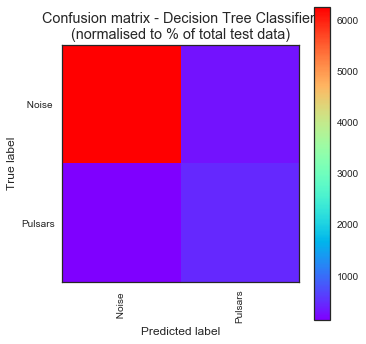

In [28]:
plotCM(Y_test, Y_pred)

____

### 3.5 KMeans vs. Agglomerative Clustering

To understand the difference between these two clustering algorithms, let's visualise how differently they choose the centroids

In [29]:
pca = PCA(n_components=8)
X1 = pca.fit_transform(X)

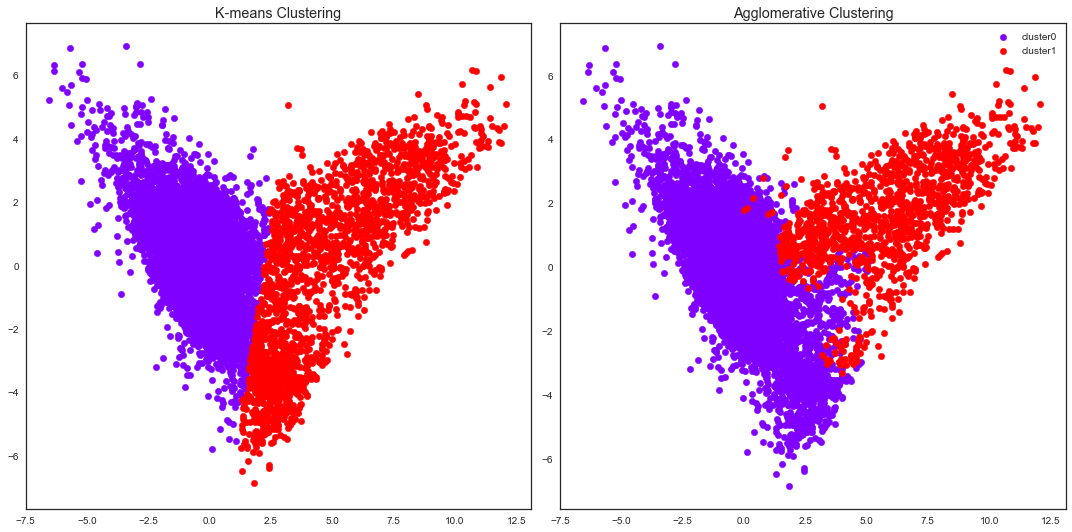

In [30]:
from matplotlib.pyplot import cm 
n=2
c = []
color=iter(cm.rainbow(np.linspace(0,1,n)))
for i in range(n):
    c.append(next(color))


n = 2
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))


km = KMeans(n_clusters= n , random_state=0)
y_km = km.fit_predict(X1)

for i in range(n):
    ax1.scatter(X1[y_km==i,0], X1[y_km==i,1], c=c[i], marker='o', s=40, label='cluster{}'.format(i))   
ax1.set_title('K-means Clustering')


ac = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(X1)

for i in range(n):
    ax2.scatter(X1[y_ac==i,0], X1[y_ac==i,1], c=c[i], marker='o', s=40, label='cluster{}'.format(i))
ax2.set_title('Agglomerative Clustering')


# Put a legend below current axis
plt.legend()
    
plt.tight_layout()
#plt.savefig('./figures/kmeans_and_ac.png', dpi=300)
plt.show()

____

# 4. Classification- A Supervised Learning Task

#### **TIP:**

1. [Cross Validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)


## 4.1 Decision Tree Classifier

In [31]:
dt = DecisionTreeClassifier(min_samples_split=20,random_state=99)

In [32]:
tt0=time()

print ("--Cross Validation Result--")
scores = model_selection.cross_val_score(dt, X,Y, cv=5)
print (scores)
print (scores.mean())
tt1=time()
print ("Time Elapsed: ", tt1-tt0)

--Cross Validation Result--
[ 0.97122905  0.97234637  0.97402235  0.96899441  0.9765232 ]
0.972623075218
Time Elapsed:  0.9382190704345703


In [33]:
t0=time()
print ("DECISION TREE: ")

clf_dt= dt.fit(X_train,Y_train)

print ("Acurracy: ", clf_dt.score(X_test,Y_test))
t1=time()
print ("Time Elapsed: ", t1-t0)

DECISION TREE: 
Acurracy:  0.970111731844
Time Elapsed:  0.11507940292358398


In [34]:
# Predict clusters on testing data
Y_pred = clf_dt.predict(X_test)

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      6566
          1       0.83      0.80      0.82       594

avg / total       0.97      0.97      0.97      7160

Confusion matrix
[[6468   98]
 [ 116  478]]


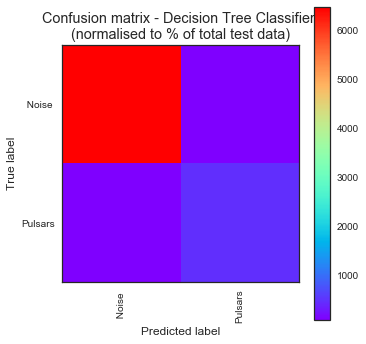

In [35]:
plotCM(Y_test, Y_pred)

___

## 4.2 Random Forest Classifier

In [36]:
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

In [37]:
tt2=time()
print ("--Cross Validation Result--")
scores = model_selection.cross_val_score(rf, X,Y, cv=5)
print (scores)
print (scores.mean())
tt3=time()
print ("Time Elapsed: ", tt3-tt2)

--Cross Validation Result--
[ 0.97765363  0.98156425  0.97960894  0.97513966  0.9784796 ]
0.978489215597
Time Elapsed:  6.547849178314209


In [38]:
t2=time()
print ("RANDOM FOREST: ")
clf_rf = rf.fit(X_train,Y_train)
print ("Acurracy: ", clf_rf.score(X_test,Y_test))
t3=time()

print ("Time Elapsed: ", t3-t2)

RANDOM FOREST: 
Acurracy:  0.980167597765
Time Elapsed:  1.063206434249878


In [39]:
Y_pred = rf.predict(X_test)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      6566
          1       0.93      0.82      0.87       594

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6529   37]
 [ 105  489]]


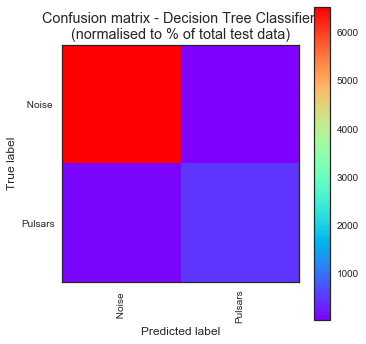

In [40]:
plotCM(Y_test, Y_pred)

___

## 4.3 Naive Bayes Classifier


In [41]:
nb = BernoulliNB()

In [42]:
tt4=time()
print ("--Cross Validation Result--")
scores = model_selection.cross_val_score(nb, X,Y, cv=5)
print (scores)
print (scores.mean())
tt5=time()
print ("Time Elapsed: ", tt5-tt4)

--Cross Validation Result--
[ 0.95223464  0.9452514   0.94581006  0.95055866  0.95556177]
0.949883302991
Time Elapsed:  0.132066011428833


In [43]:
t4=time()
print ("NAIVE BAYES: ")
clf_nb=nb.fit(X_train,Y_train)
print ("Acurracy: ", clf_nb.score(X_test,Y_test))
t5=time()
print ("Time Elapsed: ", t5-t4)

NAIVE BAYES: 
Acurracy:  0.949720670391
Time Elapsed:  0.010007381439208984


In [44]:
Y_predict = nb.predict(X_test)

             precision    recall  f1-score   support

          0       0.99      0.96      0.97      6566
          1       0.65      0.86      0.74       594

avg / total       0.96      0.95      0.95      7160

Confusion matrix
[[6287  279]
 [  81  513]]


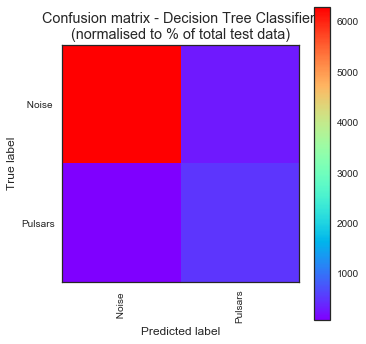

In [45]:
plotCM(Y_test,Y_predict)

___

## 4.4 KNN Classifier

In [46]:
t6=time()
print ("KNN: ")
knn = KNeighborsClassifier(n_neighbors=2)
knn = KNeighborsClassifier()
clf_knn=knn.fit(X_train, Y_train)
print ("Acurracy: ", clf_knn.score(X_test,Y_test) )
t7=time()
print ("Time Elapsed: ", t7-t6)

KNN: 
Acurracy:  0.978770949721
Time Elapsed:  0.1706843376159668


In [47]:
tt6=time()
print ("--Cross Validation Result--")
scores = model_selection.cross_val_score(clf_knn, X,Y, cv=5)
print (scores)
print (scores.mean())
tt7=time()
print ("Time Elapsed: ", tt7-tt6)

--Cross Validation Result--
[ 0.97625698  0.97932961  0.98072626  0.97709497  0.97568474]
0.977818512261
Time Elapsed:  0.5076839923858643


In [48]:
Y_predict = clf_knn.predict(X_test)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      6566
          1       0.92      0.81      0.86       594

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6526   40]
 [ 112  482]]


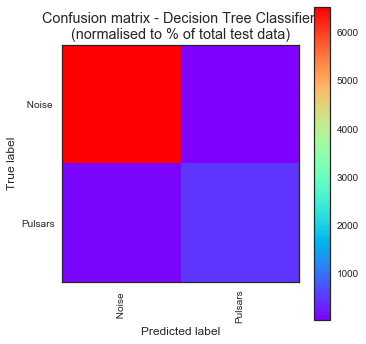

In [49]:
plotCM(Y_test,Y_predict)

___

## 4.5 SVM Classifier

### 4.5.1 SVM with a Linear Kernel 

In [50]:
t7=time()
print ("SVM (No Kernel): ")

svc = SVC()
clf_svc=svc.fit(X_train, Y_train)
print ("Acurracy: ", clf_svc.score(X_test,Y_test) )
t8=time()
print ("time elapsed: ", t8-t7)

SVM (No Kernel): 
Acurracy:  0.97905027933
time elapsed:  0.40779709815979004


In [51]:
Y_pred = svc.predict(X_test)

             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6648
          1       0.80      0.93      0.86       512

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6532  116]
 [  34  478]]


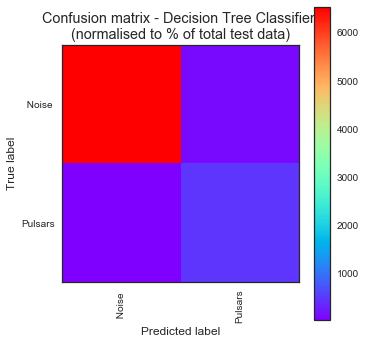

In [52]:
plotCM(Y_pred,Y_test)

In [53]:
tt7=time()
print ("--Cross Validation Result--")
scores = model_selection.cross_val_score(clf_svc, X,Y, cv=5)
print (scores)
print (scores.mean())
tt8=time()
print ("Time Elapsed: ", tt8-tt7)

--Cross Validation Result--
[ 0.97486034  0.97932961  0.98044693  0.97681564  0.97540525]
0.97737155366
Time Elapsed:  2.8686771392822266


### 4.5.2 SVM with Multiple Kernels 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.6s finished


Best score: 0.980
Best parameters set:
	C: 10
	kernel: 'rbf'
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      6566
          1       0.93      0.80      0.86       594

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6532   34]
 [ 116  478]]


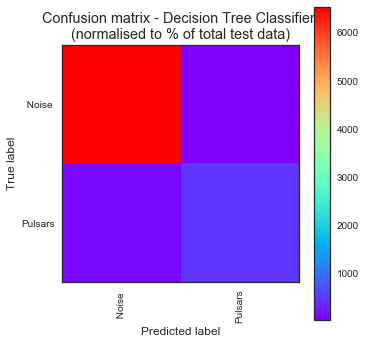

In [54]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import model_selection

svc = SVC()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}

grid = model_selection.GridSearchCV(svc, parameters, n_jobs=-1, verbose=1, scoring='accuracy')


grid.fit(X_train, Y_train)

print ('Best score: %0.3f' % grid.best_score_)

print ('Best parameters set:')
best_parameters = grid.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))
    
predictions = grid.predict(X_test)
#print (classification_report(Y_test, predictions))
plotCM(Y_test,Y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.0s finished


Best score: 0.980
Best parameters set:
	clf__C: 3
	clf__gamma: 0.3
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      6566
          1       0.93      0.80      0.86       594

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6532   34]
 [ 117  477]]


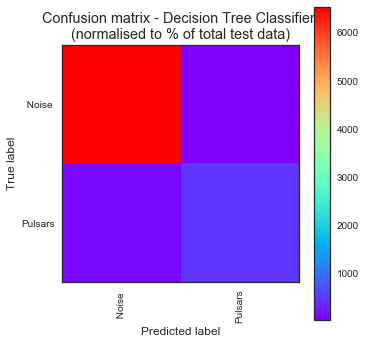

In [55]:
pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', gamma=0.01, C=100))
])

parameters = {
    'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
    'clf__C': (0.1, 0.3, 1, 3, 10, 30),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, Y_train)

print ('Best score: %0.3f' % grid_search.best_score_)

print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))
    
predictions = grid_search.predict(X_test)
plotCM(Y_test, predictions)

___

## 4.6 Leveraging weak learners via Adaptive Boosting

Decision tree train/test accuracies 0.976/0.977
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6609
          1       0.82      0.89      0.85       551

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6504  105]
 [  62  489]]


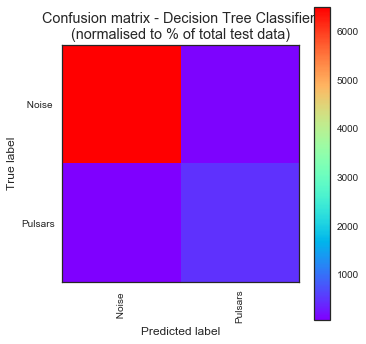

In [56]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

tree = tree.fit(X_train, Y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(Y_train, y_train_pred)
tree_test = accuracy_score(Y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))
plotCM(y_test_pred,Y_test)

AdaBoost train/test accuracies 0.979/0.980
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6640
          1       0.82      0.93      0.87       520

avg / total       0.98      0.98      0.98      7160

Confusion matrix
[[6531  109]
 [  35  485]]


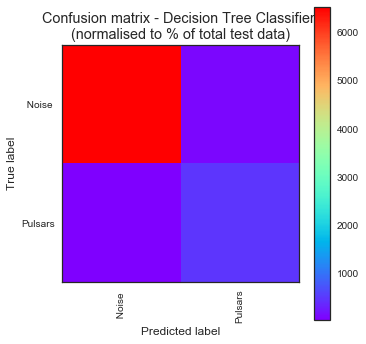

In [57]:
ada = ada.fit(X_train, Y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(Y_train, y_train_pred) 
ada_test = accuracy_score(Y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))
plotCM(y_test_pred,Y_test)